## A simple use case - prediciting Amazon stock prices using the randomized signature of correlated paths

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from timeit import default_timer as timer
import math
import pandas as pd
from datetime import datetime
from datetime import date

In [26]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

sigm_v = np.vectorize(sigmoid)

def scaling(d, M):
    r = 1
    for i in range(d):
        r += M ** (i+1)
    return r

In [27]:
def process_df(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')
    start = date.fromisoformat('2022-06-24')
    end = date.fromisoformat('2023-06-23')
    new_dates = pd.date_range(start=start,end=end,freq='D')
    df = df.reindex(new_dates)
    assert( len(df) == 365 )
    df["Open"] = df["Open"].interpolate()
    df["Open"] =( df["Open"] - df["Open"].mean() ) / df["Open"].std()
    return(df["Open"])

## Import, clean and preprocess finance data

In [28]:
file_paths = [r'datasets\cov_^N225.csv', r'datasets\cov_^NDX.csv', r'datasets\cov_^NYA.csv',
             r'datasets\cov_^SPX.csv', r'datasets\cov_^TNX.csv', r'datasets\cov_^VIX.csv',
             r'datasets\cov_^XAU.csv', r'datasets\cov_^XOI.csv', r'datasets\cov_000300.SS.csv',
             r'datasets\cov_BTC-USD.csv', r'datasets\cov_CGW.csv', r'datasets\cov_DAX.csv',
             r'datasets\cov_EURUSD=X.csv', r'datasets\cov_FEZ.csv', r'datasets\cov_GBPUSD=X.csv',
              r'datasets\cov_INDEX.csv', r'datasets\cov_MME=F.csv', r'datasets\cov_USDJPY=X.csv', 
              r'datasets\cov_VGSLX.csv', r'datasets\cov_VTI.csv'
             ]
amazon_file_path = r'datasets\target_AMZN.csv'
len(file_paths)

20

In [29]:
df_amzn = pd.read_csv(amazon_file_path)

In [30]:
df_amzn['Date'] = pd.to_datetime(df_amzn['Date'])

In [31]:
df_amzn = df_amzn.set_index('Date')

In [32]:
start = date.fromisoformat('2022-06-24')
end = date.fromisoformat('2023-06-23')

In [33]:
new_dates = pd.date_range(start=start,end=end,freq='D')
df_amzn = df_amzn.reindex(new_dates)

In [34]:
assert( len(df_amzn) == 365 )
df_amzn["Open"] = df_amzn["Open"].interpolate()
df_amzn["Open"] =( df_amzn["Open"] - df_amzn["Open"].mean() ) / df_amzn["Open"].std()
df_amzn.rename(columns={"Open": "amzn"})

df_amzn["amzn"] = df_amzn["Open"]

df_amzn = df_amzn.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])

df_amzn

,amzn
2022-06-24,0.254158
2022-06-25,0.355996
2022-06-26,0.457834
2022-06-27,0.559671
2022-06-28,0.326807
...,...
2023-06-19,1.115239
2023-06-20,1.070807
2023-06-21,1.114266
2023-06-22,1.092861


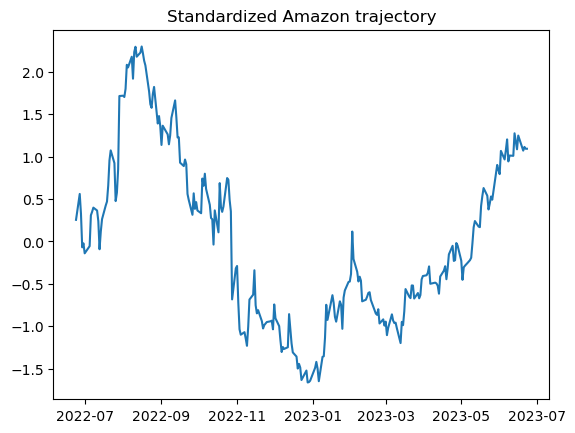

In [35]:
plt.plot(df_amzn.index,df_amzn['amzn'])
plt.title("Standardized Amazon trajectory")
plt.show()

In [36]:
path = file_paths[0]
path

'datasets\\cov_^N225.csv'

In [37]:
process_df(path)

2022-06-24   -1.113145
2022-06-25   -1.005608
2022-06-26   -0.898071
2022-06-27   -0.790535
2022-06-28   -0.756677
                ...   
2023-06-19    3.625187
2023-06-20    3.311538
2023-06-21    3.268215
2023-06-22    3.417387
2023-06-23    3.430168
Freq: D, Name: Open, Length: 365, dtype: float64

In [38]:
i = 1
for path in file_paths:
    df_amzn['cov' + str(i)] = process_df(path)
    i+=1

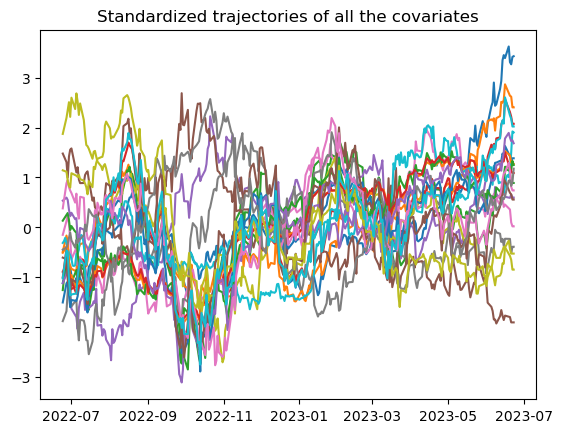

In [39]:
for i in range(1, 21):
    plt.plot(df_amzn.index, df_amzn['cov' + str(i)])
plt.title("Standardized trajectories of all the covariates")
plt.show()

## Switch to generic vector representation

In [40]:
amzn_array = df_amzn['amzn'].to_numpy()
amzn_array.shape

(365,)

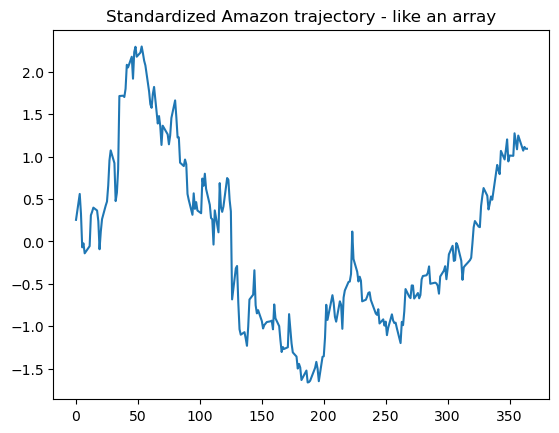

In [41]:
plt.plot(amzn_array)
plt.title("Standardized Amazon trajectory - like an array")
plt.show()

In [42]:
cov_array = np.zeros((365, 20))
for i in range(1, 21):
    cov_array[:,i-1] = df_amzn['cov' + str(i)].to_numpy()

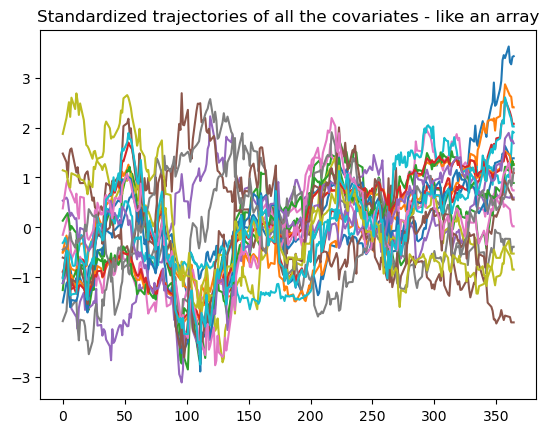

In [43]:
for i in range(1, 21):
    plt.plot(cov_array[:,i-1])
plt.title("Standardized trajectories of all the covariates - like an array")
plt.show()

## Compute a lower-dimensional randomized signature of the covariate process

In [163]:
k = 30
A = np.random.normal(0, 1, size=(20, k, k))
b = np.random.normal(0, 1, size=(20,k))
dcov = np.diff(cov_array, axis = 0)
Z = np.zeros((365, k))
Z[0][0] = 1

In [166]:
for i in range(364):
    auxiliary = 0
    for j in range(20):
        auxiliary += (1/10)*sigm_v(A[j]@Z[i] + b[j])*dcov[i][j]
    Z[i+1] = Z[i] + auxiliary

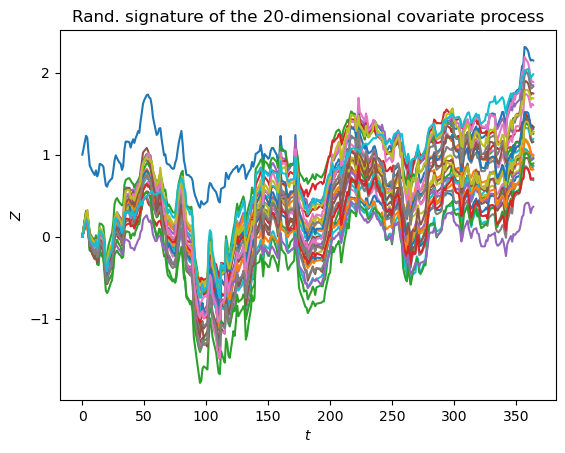

In [167]:
for i in range(k):
    plt.plot(Z[:,i])

plt.title("Rand. signature of the 20-dimensional covariate process")
plt.xlabel("$t$")
plt.ylabel("$Z$")
plt.show()

## Use to signature to approximate the price of Amazon

In [231]:
days_for_training = 330

In [232]:
Z.shape

(365, 30)

In [233]:
Z[:days_for_training,].shape

(330, 30)

In [234]:
amzn_array.shape

(365,)

In [235]:
amzn_array[:days_for_training,].shape

(330,)

In [236]:
model1 = Ridge(alpha=1).fit(Z[:days_for_training,], amzn_array[:days_for_training,])

In [237]:
r_sq_1 = model1.score(Z[:days_for_training,], amzn_array[:days_for_training,])
print(f"coefficient of determination: {r_sq_1}")

coefficient of determination: 0.9538648590146945


In [238]:
print(f"intercept: {model1.intercept_}")

intercept: -0.34469172417315885


In [239]:
#print(f"coefficients: {model1.coef_}")

In [240]:
amzn_pred_1 = model1.predict(Z)

In [241]:
range(30,200)

range(30, 200)

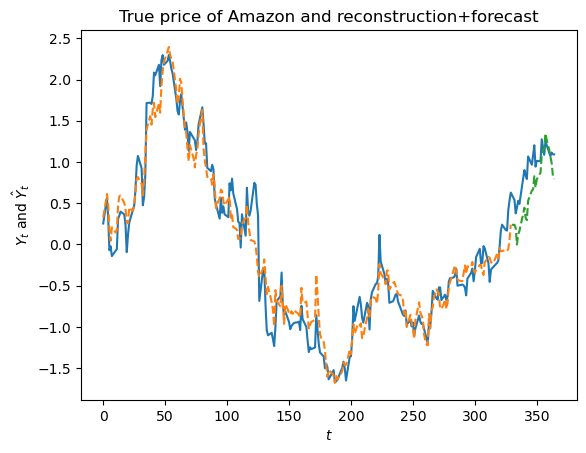

In [242]:
plt.plot(range(365),amzn_array)
plt.plot(range(days_for_training),amzn_pred_1[0:days_for_training], '--')
plt.plot(range(days_for_training,365),amzn_pred_1[days_for_training:], '--')
plt.title("True price of Amazon and reconstruction+forecast")
plt.xlabel("$t$")
plt.ylabel("$Y_t$ and $\hat{Y}_t$")
plt.show()

In [243]:
np.linalg.norm(amzn_array[days_for_training:]-amzn_pred_1[days_for_training:])/np.linalg.norm(amzn_array[days_for_training:])

0.3334744247963115

In [460]:
amzn_pred_1_series = pd.Series(amzn_pred_1)
amzn_pred_1_series = amzn_pred_1_series.set_axis(df_amzn.index)
df_amzn["amzn_pred_1"] = amzn_pred_1_series

In [461]:
df_amzn

,amzn,cov1,cov2,cov3,cov4,cov5,cov6,cov7,cov8,cov9,...,cov12,cov13,cov14,cov15,cov16,cov17,cov18,cov19,cov20,amzn_pred_1
2022-06-24,0.254158,-1.113145,-0.485215,-1.256581,-1.001425,-1.119453,1.479683,-0.149287,-1.878855,1.872675,...,-0.509194,0.133986,-0.889135,0.535320,-0.605506,0.380609,-0.446109,1.143299,-1.019746,0.198079
2022-06-25,0.355996,-1.005608,-0.377882,-1.023111,-0.811163,-1.058843,1.422517,-0.056836,-1.812067,1.979938,...,-0.466584,0.172904,-0.842899,0.555963,-0.616218,0.548613,-0.431551,1.133825,-0.833151,0.314433
2022-06-26,0.457834,-0.898071,-0.270550,-0.789642,-0.620902,-0.998233,1.365351,0.035616,-1.745278,2.087202,...,-0.423974,0.211822,-0.796662,0.576607,-0.626930,0.716616,-0.416992,1.124350,-0.646555,0.394338
2022-06-27,0.559671,-0.790535,-0.163217,-0.556172,-0.430640,-0.937622,1.308185,0.128067,-1.678489,2.194466,...,-0.381364,0.250740,-0.750426,0.597250,-0.637642,0.884619,-0.402434,1.114876,-0.459959,0.498993
2022-06-28,0.326807,-0.756677,-0.296100,-0.515543,-0.475376,-0.780586,0.996372,0.252836,-1.278302,2.346533,...,-0.351865,0.288186,-0.742266,0.548552,-1.048989,0.949236,-0.329051,0.934859,-0.482541,0.479788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-19,1.115239,3.625187,2.694659,1.139772,2.374341,0.596921,-1.789347,0.383367,-0.230036,-0.267138,...,1.463147,1.204634,1.260855,1.893469,0.752263,1.291705,0.936359,-0.528964,2.334217,0.968766
2023-06-20,1.070807,3.311538,2.637219,1.126416,2.309716,0.591411,-1.796585,0.358532,-0.230911,-0.433685,...,1.441023,1.159424,1.179261,1.801393,0.692810,1.136623,0.942654,-0.572784,2.243891,0.898762
2023-06-21,1.114266,3.268215,2.620222,0.876312,2.216900,0.657532,-1.903493,0.097867,-0.513305,-0.525141,...,1.296805,1.149454,1.130306,1.729627,0.660674,0.813541,0.831695,-0.648581,2.177335,0.846574
2023-06-22,1.092861,3.417387,2.405103,0.890135,2.075026,0.596921,-1.903493,0.020781,-0.388124,-0.525141,...,1.270584,1.332804,1.089509,1.745116,0.557838,0.740309,0.901143,-0.846362,2.021639,0.727375
